In [1]:
# general packages
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# image loading, pre-trained CNN
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# anomaly detection
from sklearn import svm
from sklearn.ensemble import IsolationForest

# scaling and dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# classification metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

In [2]:
# load image paths from folders
train_path =  'MRIscans/Training/'
val_path = 'MRIscans/Validation/'
test_path = 'MRIscans/Testing/'

train_files = glob.glob(os.path.join(train_path, 'no_tumor_train', '*.*'))
val_files = glob.glob(os.path.join(val_path, 'no_tumor_val', '*.*'))

test_files_pos = glob.glob(os.path.join(test_path, 'tumor_test', '*.*'))
test_files_neg = glob.glob(os.path.join(test_path, 'no_tumor', '*.*'))
test_files = test_files_pos + test_files_neg

test_labels = np.array([0]*len(test_files_pos)+[1]*len(test_files_neg))

print(f'Number of training files: {len(train_files)}')
print(f'Number of validation files: {len(val_files)}')
print(f'Number of test files: {len(test_files)}')

print(f'\nNumber of tumor images in test set: {len(test_files_pos)}')
print(f'Number of non-tumor images in test set: {len(test_files_neg)}')

Number of training files: 1841
Number of validation files: 399
Number of test files: 867

Number of tumor images in test set: 129
Number of non-tumor images in test set: 738


In [3]:
print(train_files[0])
print(val_files[0])
print(test_files[0])

MRIscans/Training/no_tumor_train\1 no.jpeg
MRIscans/Validation/no_tumor_val\Tr-no_0825.jpg
MRIscans/Testing/tumor_test\p (179).jpg


In [4]:
def read_and_prep_imgs(files):
    # load the images from the path with size 250x250
    imgs = [load_img(img_path, target_size=(250, 250)) for img_path in files]
    # convert list of images to numpy array
    dataset = np.array([img_to_array(img) for img in imgs])
    # appropriately preprocess images for resnet use
    dataset = preprocess_input(dataset)
    return dataset

In [5]:
train_dataset = read_and_prep_imgs(train_files)
val_dataset = read_and_prep_imgs(val_files)
test_dataset = read_and_prep_imgs(test_files)

print('Training Set:    ', train_dataset.shape)
print('Validation Set:  ', val_dataset.shape)
print('Testing Set:     ', test_dataset.shape)

Training Set:     (1841, 250, 250, 3)
Validation Set:   (399, 250, 250, 3)
Testing Set:      (867, 250, 250, 3)


# One-Class SVM & Isolation Forest

BASIC IDEA:
* Apply a pre-trained CNN to extract a meaningful compact representation of the images
  * Feature extraction with ResNet50
  * Removing the prediction layer of the pretrained Resnet50 model allows features to quickly be extracted from selected images
* Use those feature vectors as input to a anomaly detection algorithm
  * One-Class SVM
  * Isolation Forest

In [6]:
# don't include top layer since that fully-conneccted layer is used for predictions
resnet_model = ResNet50(input_shape=(250,250,3), weights='imagenet', include_top=False, pooling='avg')

train_features = resnet_model.predict(train_dataset)
#val_features = resnet_model.predict(val_dataset)
test_features = resnet_model.predict(test_dataset)

In [7]:
print('Train Features Length:', len(train_features))
print('Test Features Length:', len(test_features))

Train Features Length: 1841
Test Features Length: 867


In [8]:
# standardize the features vector
sc = StandardScaler()
sc.fit(train_features)
train_features_prep = sc.transform(train_features)
test_features_prep = sc.transform(test_features)

# reduce the dimensionality of the features vector
pca = PCA(n_components=512, whiten=True)
pca = pca.fit(train_features_prep)
train_features_prep = pca.transform(train_features_prep)
test_features_prep = pca.transform(test_features_prep)

print('Explained Variance {:.2%}'.format(sum(pca.explained_variance_ratio_)))

Explained Variance 97.88%


In [9]:
# anomaly detection algorithms
# TODO: hyper-parameter tuning on val set
oneclass_svm = svm.OneClassSVM(kernel='rbf')
iso_forest = IsolationForest(n_estimators=100)

oneclass_svm.fit(train_features_prep)
iso_forest.fit(train_features_prep)

oneclass_svm_preds = oneclass_svm.predict(test_features_prep)
iso_forest_preds = iso_forest.predict(test_features_prep)

In [10]:
# since the model is trained on exclusively non-tumorous brain scans,
# 0 indicates tumorous (anomaly), 1 indicates non-tumorous (normal)
oneclass_svm_preds = [0 if x == -1 else 1 for x in oneclass_svm_preds]
iso_forest_preds = [0 if x == -1 else 1 for x in iso_forest_preds]
actual_class = [0 if file.find('tumor_test') != -1 else 1 for file in test_files]

svm_iso_results = pd.DataFrame({
  'path':               test_files,
  'oneclass_svm_preds': oneclass_svm_preds,
  'iso_forest_preds':   iso_forest_preds,
  'actual_class':       actual_class
})

svm_iso_results

,path,oneclass_svm_preds,iso_forest_preds,actual_class
0,MRIscans/Testing/tumor_test\p (179).jpg,0,1,0
1,MRIscans/Testing/tumor_test\p (180).jpg,0,0,0
2,MRIscans/Testing/tumor_test\p (181).jpg,0,0,0
3,MRIscans/Testing/tumor_test\p (182).jpg,0,0,0
4,MRIscans/Testing/tumor_test\p (183).jpg,0,0,0
...,...,...,...,...
862,MRIscans/Testing/no_tumor\Tr-no_1590.jpg,1,1,1
863,MRIscans/Testing/no_tumor\Tr-no_1591.jpg,1,1,1
864,MRIscans/Testing/no_tumor\Tr-no_1592.jpg,1,1,1
865,MRIscans/Testing/no_tumor\Tr-no_1593.jpg,0,1,1


--One-Class SVM Evaluation--
ROC-AUC Score: 0.7926829268292683
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46       129
           1       1.00      0.59      0.74       738

    accuracy                           0.65       867
   macro avg       0.65      0.79      0.60       867
weighted avg       0.90      0.65      0.70       867



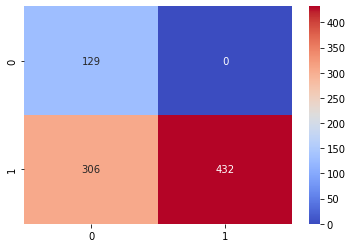

In [19]:
# one-class svm evaluation
print('--One-Class SVM Evaluation--')
print('ROC-AUC Score:', roc_auc_score(actual_class, oneclass_svm_preds))
print('Classification Report:')
print(classification_report(actual_class, oneclass_svm_preds))
sns.heatmap(confusion_matrix(actual_class, oneclass_svm_preds), annot=True, fmt = '2.0f', cmap='coolwarm')
plt.show()

> One-class SVM does a very good job at classifying anomalous data, but not that good of a job at classifying normal data

--Isolation Forest Evaluation--
ROC-AUC Score: 0.6245194428688473
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.26      0.40       129
           1       0.88      0.99      0.94       738

    accuracy                           0.88       867
   macro avg       0.88      0.62      0.67       867
weighted avg       0.88      0.88      0.86       867



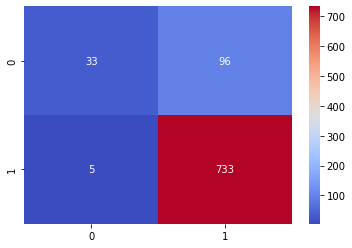

In [20]:
print('--Isolation Forest Evaluation--')
print('ROC-AUC Score:', roc_auc_score(actual_class, iso_forest_preds))
print('Classification Report:')
print(classification_report(actual_class, iso_forest_preds))
sns.heatmap(confusion_matrix(actual_class, iso_forest_preds), annot=True, fmt = '2.0f', cmap='coolwarm')
plt.show()

> Isolation Forest does a very good job at classifying normal data, but not that good of a job at classifying anomalous data

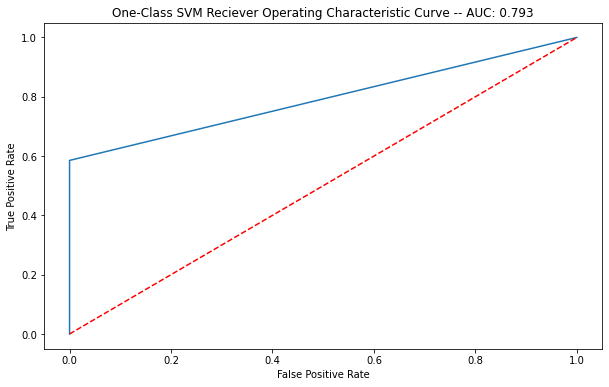

In [13]:
fpr, tpr, _ = roc_curve(actual_class, oneclass_svm_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'One-Class SVM Reciever Operating Characteristic Curve -- AUC: {roc_auc:.3f}')
plt.show()

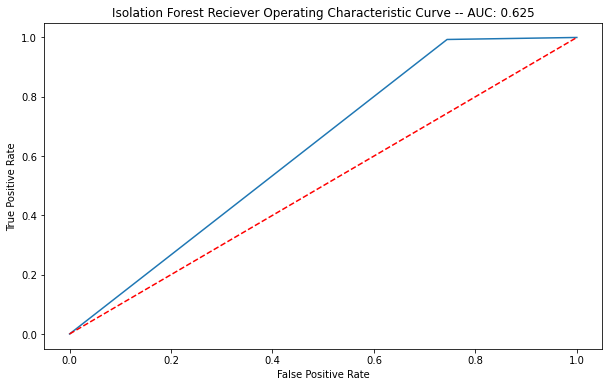

In [14]:
fpr, tpr, _ = roc_curve(actual_class, iso_forest_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'Isolation Forest Reciever Operating Characteristic Curve -- AUC: {roc_auc:.3f}')
plt.show()